In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [2]:
DTYPE = 'float32'
L63_data_path = '../data/L63-trajectories'
save_folder='../data/adaptive-rate'
log_interval = 100
milestones = [10*2**n for n in range(15)]
learning_rate = 1e-3
drop = 0.7
steps = int(2e5)
save_interval = 100
N = 2000
L0 = 0.4
L1 = 3.5
beta = 4e-5
min_change = (1.-0.1)**(1./log_interval) - 1.
train = np.load(f'{L63_data_path}/train.npy').astype(DTYPE)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(DTYPE)

model = srnn.SurrogateModel_NN(3, 100, name='nn', save_folder=save_folder)
# model.learn(train[:, :N], steps, 1e-3, batch_size='GD', log_interval=100, save_interval=1000,\
#            max_delta=0.1, min_change=min_change, constant_rate=False, update_frequency=1000, mode='BS')
# tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
# tau_f_1 = tau_f_se.mean()
# tau_f_1

In [3]:
model.net.state_dict()['2.weight'].requires_grad

False

In [4]:
(torch.sum(model.net[2].weight**2))

tensor(1.0321, grad_fn=<SumBackward0>)

In [5]:
a = torch.rand((3,3))
model.net(a)

tensor([[-0.1320, -0.5176, -0.1620],
        [-0.1922, -0.4747, -0.1670],
        [-0.1753, -0.4810, -0.1966]], grad_fn=<MmBackward0>)

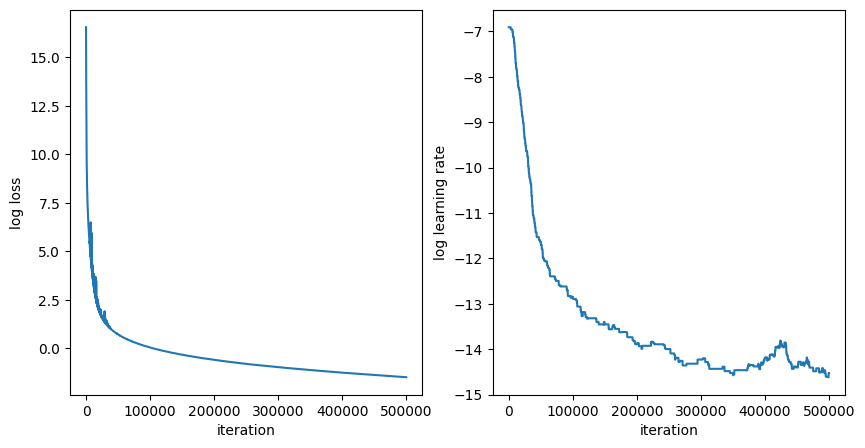

In [6]:
save_folder = '../data/nn_adaptive_lr_s'
title = 'adaptive learning rate, mode = bisection'
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df = pd.read_csv(f'{save_folder}/train_log.csv')
ax1.plot(df['iteration'], np.log(df['loss']))
ax2.plot(df['iteration'], np.log(df['learning_rate']))
ax1.set_xlabel('iteration')
ax1.set_ylabel('log loss')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log learning rate')
plt.savefig(f'{save_folder}/loss_lr.png')

In [7]:
df['loss'].to_numpy()[-1]

0.2262314522410482

Time taken by compute_tau_f is 6.6667 seconds
Time taken by compute_tau_f is 6.6423 seconds
Time taken by compute_tau_f is 6.6224 seconds
Time taken by compute_tau_f is 6.5991 seconds


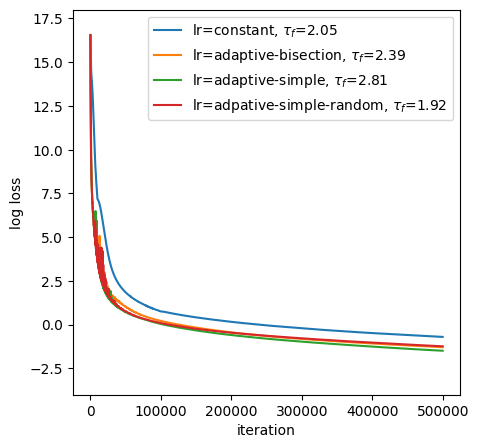

In [18]:
save_folders = ['../data/nn_0', '../data/nn_adaptive_lr_bs', '../data/nn_adaptive_lr_s', '../data/nn_adaptive_lr_sr']
labels = ['lr=constant', 'lr=adaptive-bisection', 'lr=adaptive-simple', 'lr=adpative-simple-random']
names = ['nn_0', 'nn', 'nn', 'nn']

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
i = 0
for save_folder in save_folders:
    model = srnn.SurrogateModel_NN(3, 100, name=names[i], save_folder=save_folder)
    model.load(490000)
    model.net.float()
    tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:500], error_threshold=0.05)
    df = pd.read_csv(f'{save_folder}/train_log.csv')
    df = df[df['iteration'] < 5e5]
    ax1.plot(df['iteration'], np.log(df['loss']), label=labels[i] + fr', $\tau_f$={tau_f_se.mean():.2f}')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('log loss')
    i += 1
ax1.set_ylim((-4, 18))
ax1.legend()
plt.savefig(f'../data/plots/loss_adaptive.png')